# Dimensionality reduction

---

Aditya Marathe

## Imports and version

In [1]:
# %matplotlib inline

import sys

import numpy as np
import numpy.typing as npt

import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

**Local**:

In [2]:
sys.path.insert(1, './../')

import ana
from utils import *
from transforms import *

In [3]:
ana.init_global_plotting_style()

**Version**:

In [4]:
print(f'Python {sys.version}\n')
print(f'NumPy {np.__version__}')
print(f'Matplotlib {mpl.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

NumPy 1.26.1
Matplotlib 3.8.1


## Load dataset

In [5]:
ds = Datasets()

Datasets found:
- MINI_DATA_DIR
- DATA_V2_DIR
- DATA_V3_DIR
- REALLY_MINI_DIR
- COPYMERGED_C6_DIR
- COPYMERGED_C7_DIR
- COPYMERGED_C8_DIR
- COPYMERGED_C9_DIR
- COPYMERGED_C10_DIR


In [6]:
data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        # ds.COPYMERGED_C8_DIR,  # type: ignore
        # ds.COPYMERGED_C9_DIR,  # type: ignore
        ds.COPYMERGED_C10_DIR  # type: ignore
    ]
)

In [7]:
data.table.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 184661 entries, (15021, 10, 0, 0, 1, 1) to (15112, 63, 0, 0, 1000, 2)
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   rec.energy.numu.E                   184661 non-null  float32
 1   rec.energy.numu.calccE              184661 non-null  float32
 2   rec.energy.numu.hadcalE             184661 non-null  float32
 3   rec.energy.numu.hadtrkE             184661 non-null  float32
 4   rec.energy.numu.lstmmuon            184661 non-null  float32
 5   rec.energy.numu.lstmnu              184661 non-null  float32
 6   rec.energy.numu.regcvnhadE          184661 non-null  float32
 7   rec.energy.numu.trkccE              184661 non-null  float32
 8   rec.energy.numu.recomuonE           184661 non-null  float32
 9   rec.energy.numu.hadclust.calE       184661 non-null  float32
 10  rec.energy.numu.hadclust.nhit       184661 non-nul

In [8]:
data.fill_ana_flags(inplace=True)
data.fill_ana_track_kinematics(inplace=True)

## Data prep.

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
cuts = ana.Cuts.init_nova_cuts()

In [11]:
table = data.table.reset_index(drop=True)

In [12]:
# Cuts
table = cuts.apply_cut('Detector Quality', table)
table = cuts.apply_cut('Data Quality', table)
table = cuts.apply_cut('Cosmic Rej.', table)
table = cuts.apply_cut('Veto', table)
# table = cuts.apply_cut('CVN PID Score', table)
# table = cuts.apply_cut('Containment', table)

In [13]:
# Full cuts for comparison
full_cuts_table = cuts.apply_all_cuts(table)

In [14]:
def tf_120224_first_prong(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    
    targets = [
        'ana.trk.kalman.tracks.cosBeam', 
	    'ana.trk.kalman.tracks.PtToPmu',
        'ana.trk.kalman.tracks.Pt',
        'ana.trk.kalman.tracks.Qsquared',
        'ana.trk.kalman.tracks.W'
    ]

    for target in targets:
        df_copy[target] = df_copy[target].apply(
            lambda row: row[0] if len(row) > 0 else float('nan')
        )

    return df_copy

In [15]:
def tf_200224_add_cut_vars(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()

    df_copy = cuts.apply_cut('CVN PID Score', df_copy)
    passed_cvn_pid_index = df_copy.index

    df_copy = df.copy()

    df_copy = cuts.apply_cut('Containment', df_copy)
    passed_containment_index = df_copy.index
    
    #

    df_copy = df.copy()

    df_copy.loc[passed_cvn_pid_index, 'ana.cut.flag.cvn_pid'] = 1.
    df_copy.loc[passed_containment_index, 'ana.cut.flag.containment'] = 1.

    df_copy[['ana.cut.flag.cvn_pid', 'ana.cut.flag.containment']] = df_copy[['ana.cut.flag.cvn_pid', 'ana.cut.flag.containment']].fillna(value=0)

    return df_copy


In [16]:
# Transforms
table = tf_290124_positive_energies(table)
table = tf_290124_valid_pid(table)
# table = tf_120224_numu_energy(table)
table = tf_120224_first_prong(table)
table = tf_200224_add_cut_vars(table)

In [17]:
# Transforms
full_cuts_table = tf_290124_positive_energies(full_cuts_table)
full_cuts_table = tf_290124_valid_pid(full_cuts_table)

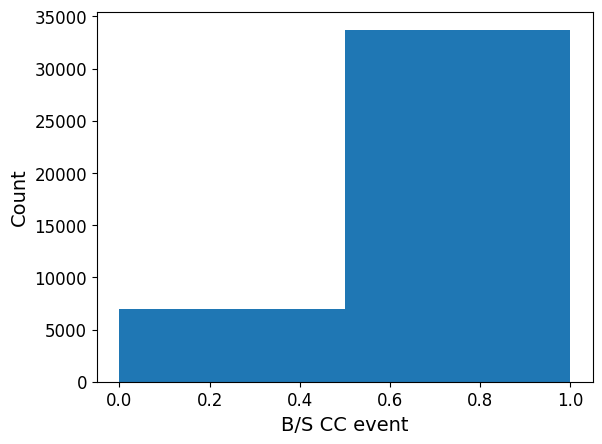

In [18]:
plt.hist(
    table['rec.mc.nu.iscc'],
    bins=np.linspace(0, 1, 2 + 1)  # type: ignore
)
plt.ylabel('Count')
plt.xlabel('B/S CC event');

In [217]:
useful_vars = [
	'rec.energy.numu.calccE',
	'rec.energy.numu.hadcalE',
	'rec.energy.numu.hadtrkE',
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.lstmnu',
	'rec.energy.numu.regcvnhadE',
	'rec.energy.numu.trkccE',
	'rec.energy.numu.recomuonE',
	'rec.energy.numu.hadclust.calE',
	'rec.energy.numu.hadclust.nhit',
	'rec.sel.contain.kalfwdcell',
	'rec.sel.contain.kalbakcell',
	'rec.sel.contain.cosfwdcell',
	'rec.sel.contain.cosbakcell',
	'rec.sel.cosrej.numucontpid2020fhc',
	'rec.sel.cvnloosepreselptp.cosmicid',
	'rec.sel.cvnloosepreselptp.ncid',
	'rec.sel.cvnloosepreselptp.nueid',
	'rec.sel.cvnloosepreselptp.numuid',
	'rec.sel.remid.pid',
	'rec.sel.scann.scpid',
	'rec.slc.calE',
	'rec.slc.firstplane',
	'rec.slc.lastplane',
	'rec.slc.nhit',
	'rec.slc.ncontplanes',
	'rec.trk.kalman.ntracks',
	'rec.trk.kalman.ntracks2d',
	'ana.trk.kalman.tracks.cosBeam', 
	'ana.trk.kalman.tracks.PtToPmu',
	'ana.trk.kalman.tracks.Pmu', 
	'ana.trk.kalman.tracks.Pt',
    'ana.cut.flag.cvn_pid',
    'ana.cut.flag.containment',
	'ana.mc.flag.isNuMuCC'
]

scale_vars = [
	'rec.energy.numu.calccE',
	'rec.energy.numu.hadcalE',
	'rec.energy.numu.hadtrkE',
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.regcvnhadE',
	'rec.energy.numu.trkccE',
	'rec.energy.numu.recomuonE',
	'rec.energy.numu.hadclust.calE',
	'rec.energy.numu.hadclust.nhit',
	'rec.sel.contain.kalfwdcell',
	'rec.sel.contain.kalbakcell',
	'rec.sel.contain.cosfwdcell',
	'rec.sel.contain.cosbakcell',
	'rec.slc.calE',
	'rec.slc.firstplane',
	'rec.slc.lastplane',
	'rec.slc.nhit',
	'rec.slc.ncontplanes',
	'rec.trk.cosmic.ntracks',
	'rec.trk.kalman.ntracks',
	'rec.trk.kalman.ntracks2d',
	'ana.trk.kalman.tracks.cosBeam', 
	'ana.trk.kalman.tracks.PtToPmu',
	'ana.trk.kalman.tracks.Pmu', 
	'ana.trk.kalman.tracks.Pt'
]

In [218]:
len(useful_vars)

35

IndexError: list index out of range

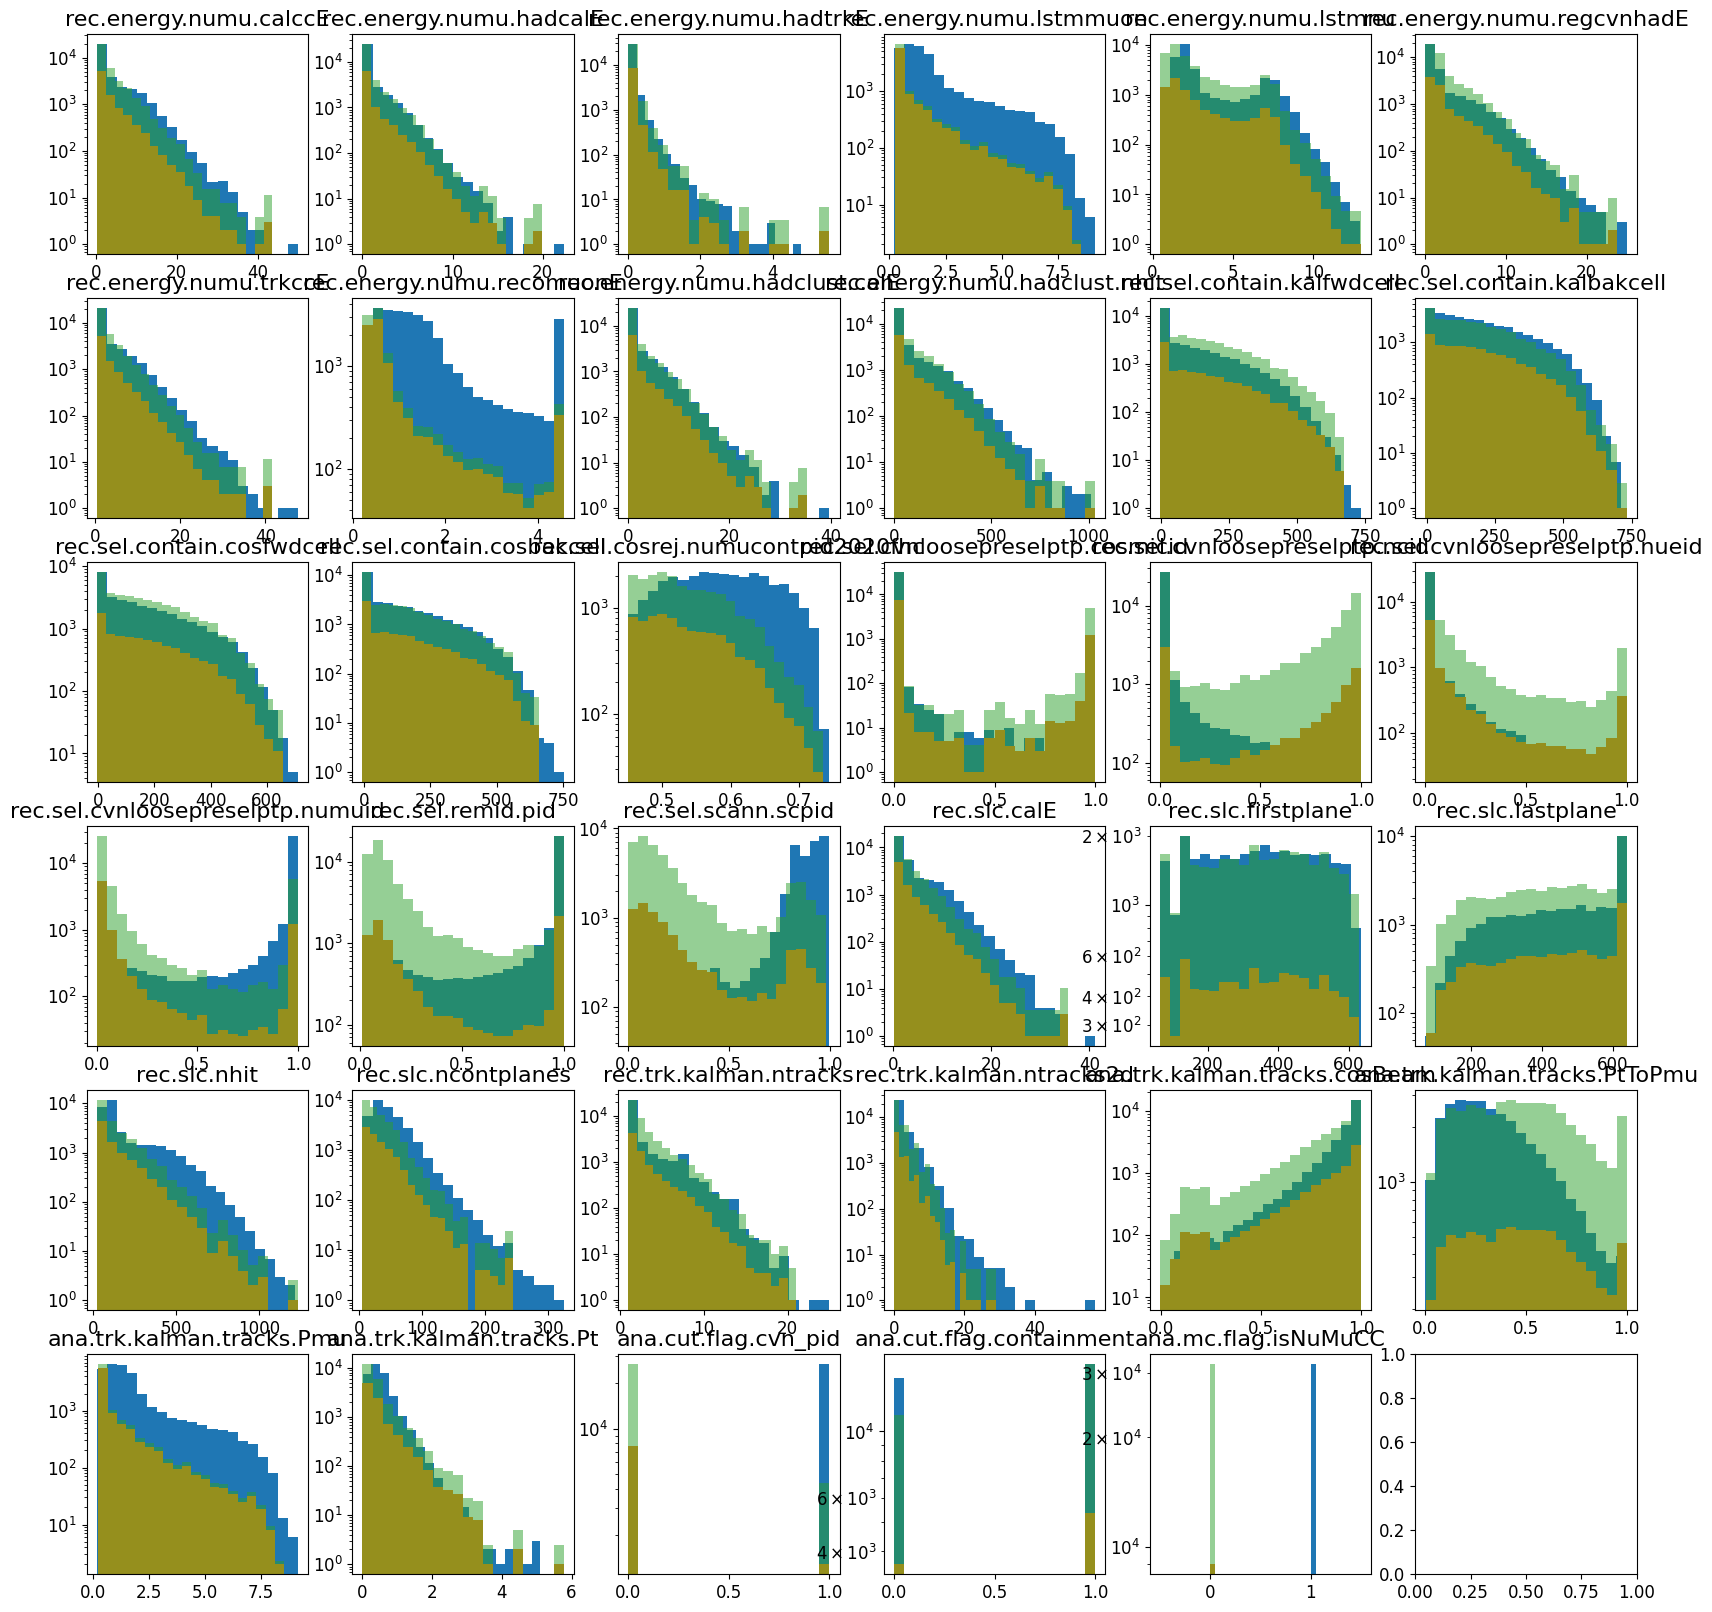

In [151]:
fig, axs = plt.subplots(6, 6, figsize=(20, 20))

axs = axs.flatten()

for i, ax in enumerate(axs):
    var = useful_vars[i]

    s_vals, edg, *_ = ax.hist(
        table[table['ana.mc.flag.isNuMuCC'] == 1][var],
        bins=20,
        label='signal'
    )
    b_vals, edg, *_ = ax.hist(
        table[table['ana.mc.flag.isNuMuCC'] == 0][var],
        bins=20,
        label='background'
    )
    ax.hist(
        edg[:-1],
        bins=edg,
        weights=b_vals * (s_vals.max() / b_vals.max()),
        alpha=0.5,
        label='scaled background'
    )
    ax.set_yscale('log')
    ax.set_title(var)

plt.tight_layout();

IndexError: list index out of range

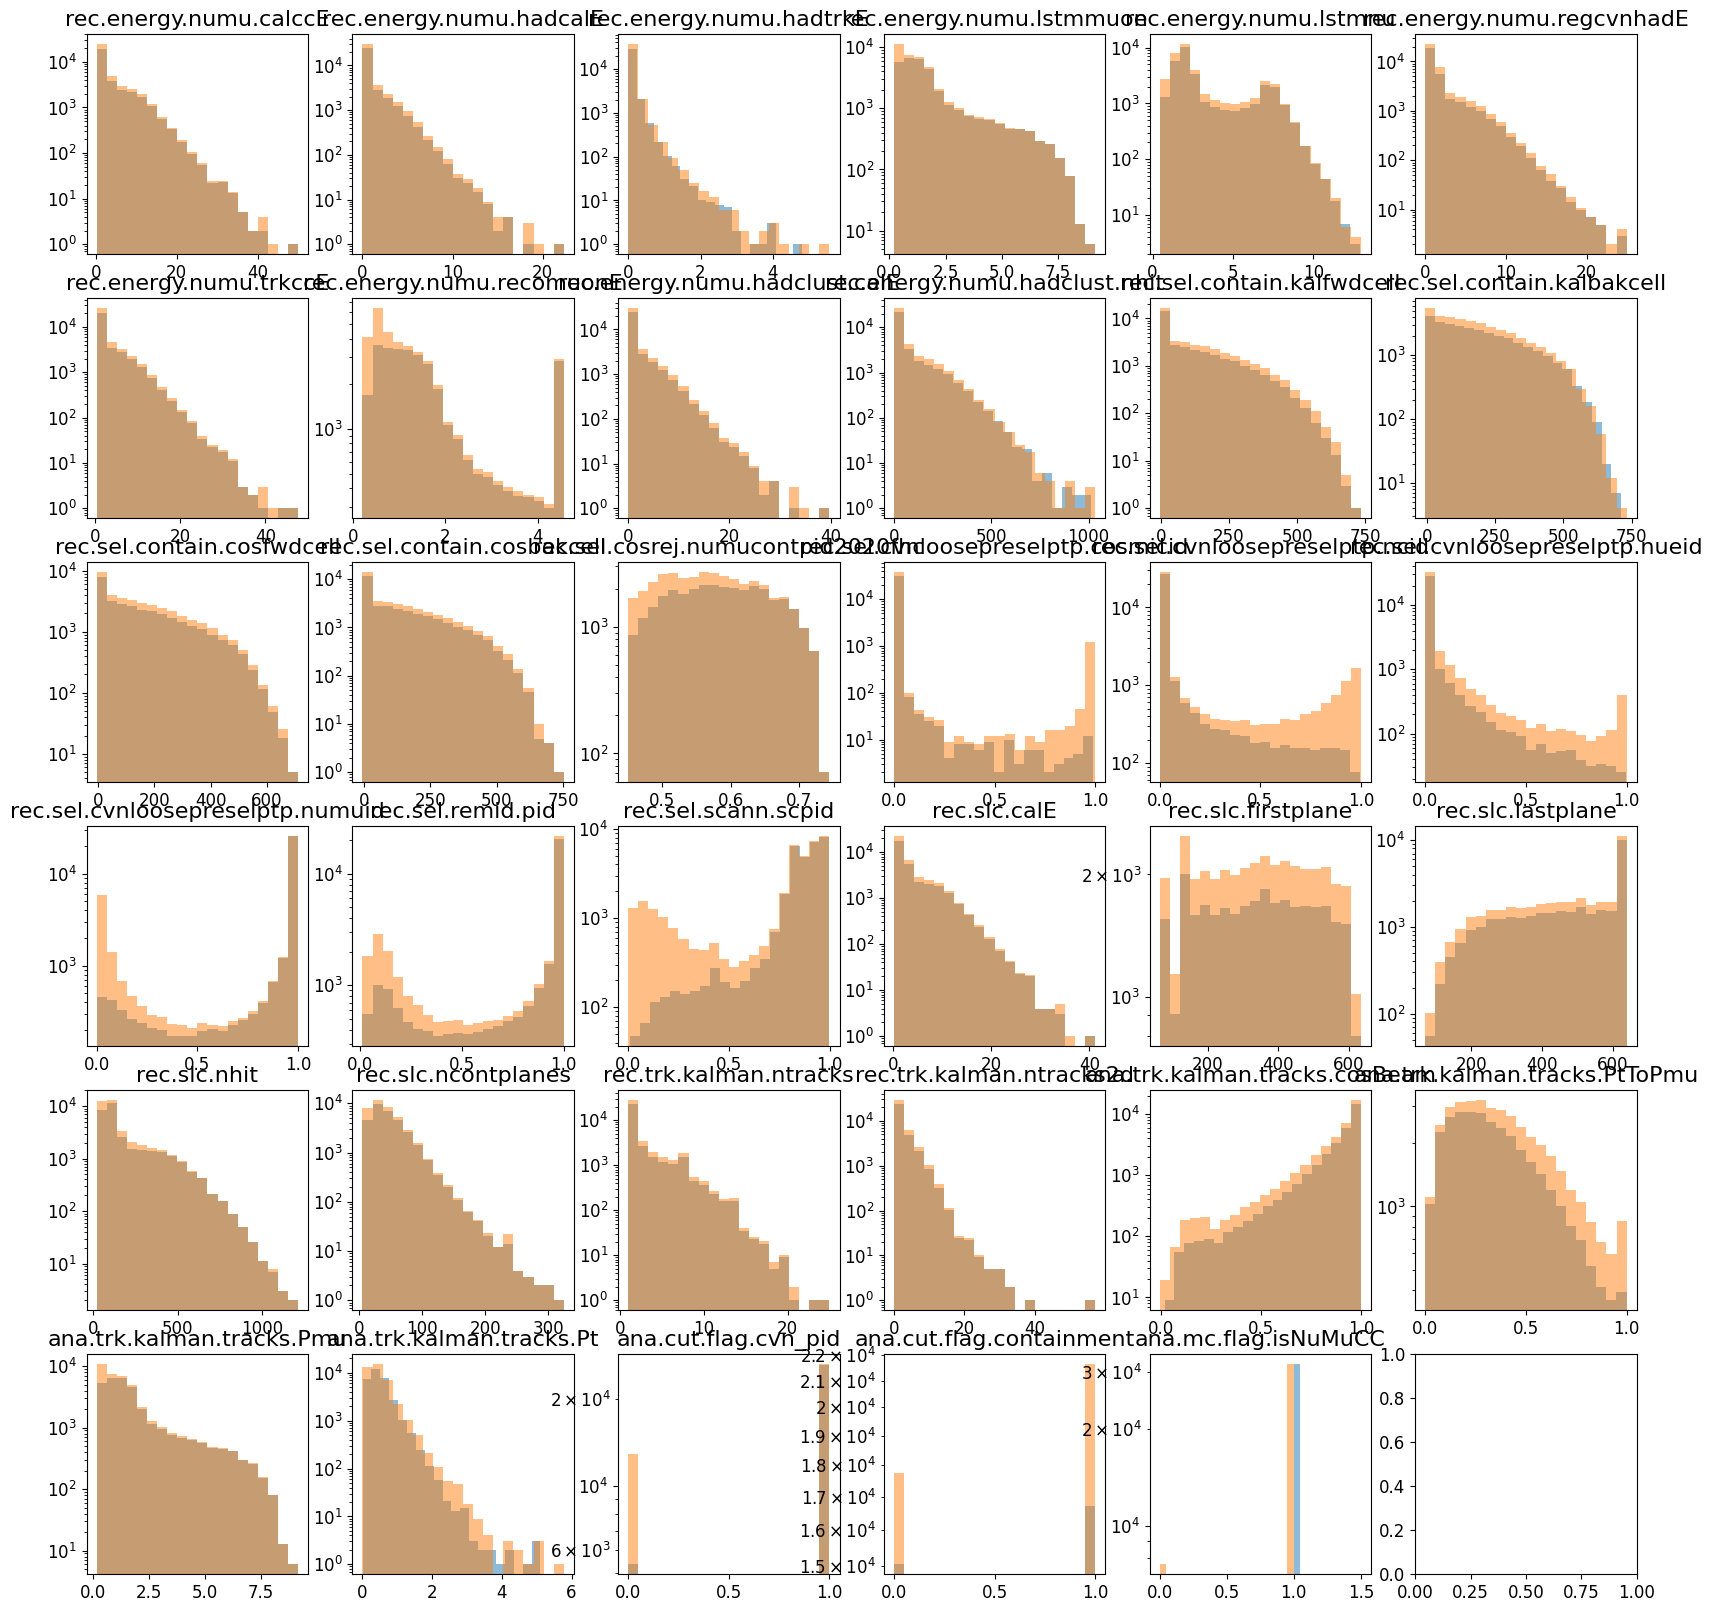

In [221]:
fig, axs = plt.subplots(6, 6, figsize=(20, 20))

axs = axs.flatten()

for i, ax in enumerate(axs):
    var = useful_vars[i]
    s_vals, edg, *_ = ax.hist(
        table[table['ana.mc.flag.isNuMuCC'] == 1][var],
        bins=20,
        alpha=0.5,
        label='numucc'
    )
    b_vals, edg, *_ = ax.hist(
        table[table['ana.mc.flag.isANuMuCC'] == 0][var],
        bins=20,
        alpha=0.5,
        label='anumucc'
    )
    ax.set_yscale('log')
    ax.set_title(var)

plt.tight_layout();

In [19]:
event_type = (
    table['ana.mc.flag.isNuMuCC'] 
    + 2 * table['ana.mc.flag.isANuMuCC'] 
    + 3 * table['ana.mc.flag.isNuECC'] 
    + 4 * table['ana.mc.flag.isNC']
)
event_type.value_counts()

1.0    31752
4.0     5636
0.0     1417
2.0     1355
3.0      574
Name: count, dtype: int64

In [20]:
table['EventType'] = event_type

In [164]:
useful_vars = [
	# 'rec.energy.numu.lstmmuon',
	# 'rec.energy.numu.recomuonE',
	# 'rec.sel.cosrej.numucontpid2020fhc',
	'rec.sel.cvnloosepreselptp.cosmicid',
	'rec.sel.cvnloosepreselptp.ncid',
	# 'rec.sel.cvnloosepreselptp.nueid',
	'rec.sel.cvnloosepreselptp.numuid',
	'rec.sel.remid.pid',
	'rec.sel.scann.scpid',
    # 'ana.cut.flag.cvn_pid',
    # 'ana.cut.flag.containment',
	# 'ana.mc.flag.isNuMuCC',
    'EventType'
]

scale_vars = [
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.recomuonE'
]

In [165]:
len(useful_vars)

6

IndexError: list index out of range

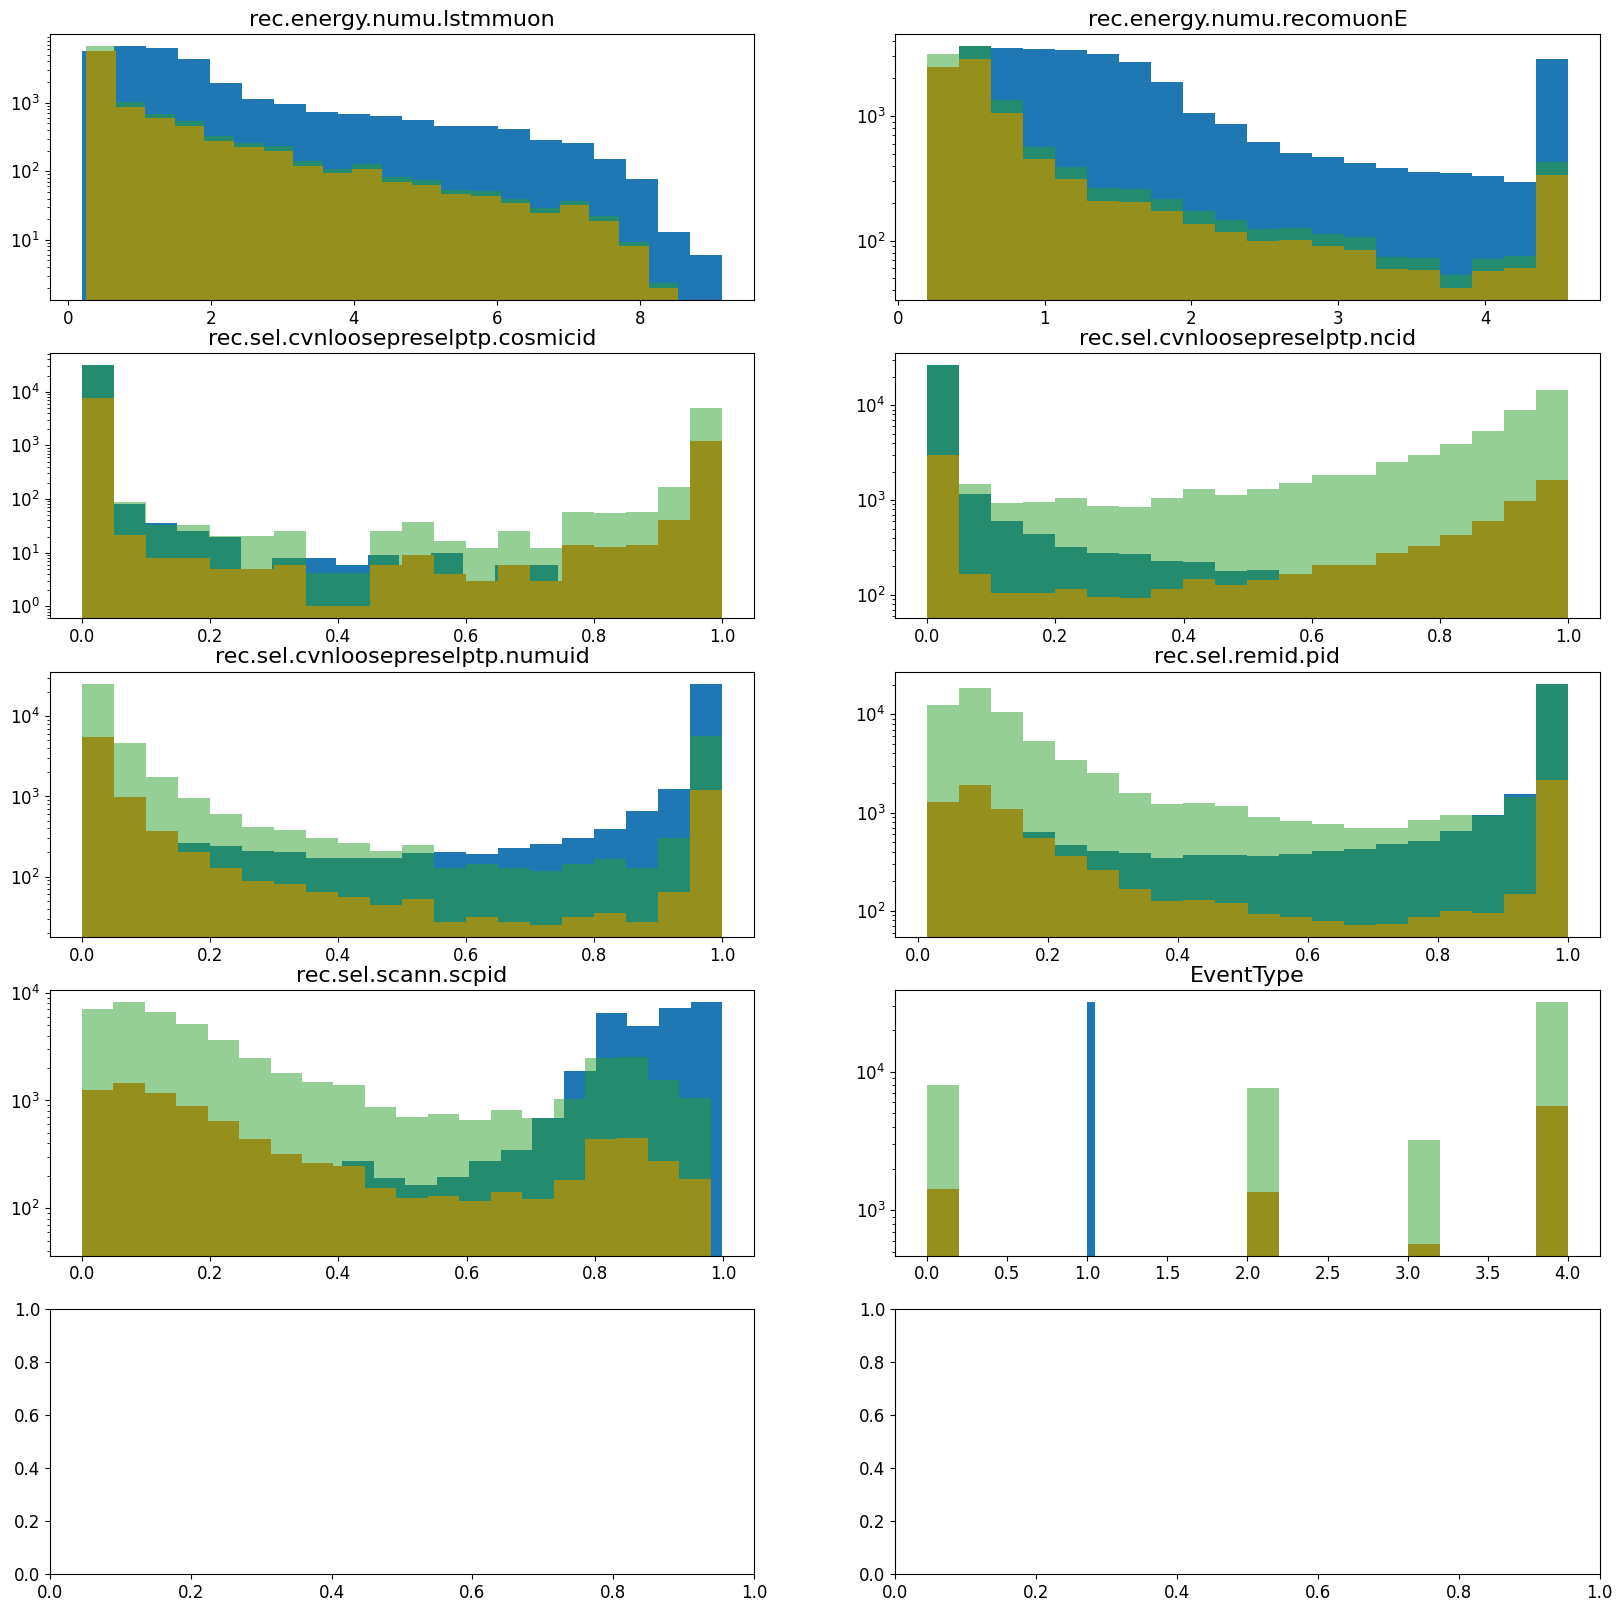

In [23]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))

axs = axs.flatten()

for i, ax in enumerate(axs):
    var = useful_vars[i]

    s_vals, edg, *_ = ax.hist(
        table[table['ana.mc.flag.isNuMuCC'] == 1][var],
        bins=20,
        label='signal'
    )
    b_vals, edg, *_ = ax.hist(
        table[table['ana.mc.flag.isNuMuCC'] == 0][var],
        bins=20,
        label='background'
    )
    ax.hist(
        edg[:-1],
        bins=edg,
        weights=b_vals * (s_vals.max() / b_vals.max()),
        alpha=0.5,
        label='scaled background'
    )
    ax.set_yscale('log')
    ax.set_title(var)

plt.tight_layout();

In [166]:
x_table = table[useful_vars]
# y_table = x_table.pop('ana.mc.flag.isNuMuCC')
y_table = x_table.pop('EventType')

In [ ]:
ss = StandardScaler()
x_table.loc[:, scale_vars] = ss.fit_transform(x_table[scale_vars])

## t-SNE plot

In [ ]:
from sklearn.manifold import TSNE

In [37]:
tsne = TSNE(
    n_components=2,
    perplexity=50,
    n_iter=2_000,
    verbose=1,
    random_state=42
)
x_tsne = tsne.fit_transform(x_table, y_table)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5567 samples in 0.007s...
[t-SNE] Computed neighbors for 5567 samples in 0.252s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5567
[t-SNE] Computed conditional probabilities for sample 2000 / 5567
[t-SNE] Computed conditional probabilities for sample 3000 / 5567
[t-SNE] Computed conditional probabilities for sample 4000 / 5567
[t-SNE] Computed conditional probabilities for sample 5000 / 5567
[t-SNE] Computed conditional probabilities for sample 5567 / 5567
[t-SNE] Mean sigma: 0.944504
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.111664
[t-SNE] KL divergence after 1000 iterations: 1.315620


In [38]:
table_tsne = pd.DataFrame(x_tsne, columns=['tsne1', 'tsne2'])
table_tsne['label'] = y_table.values

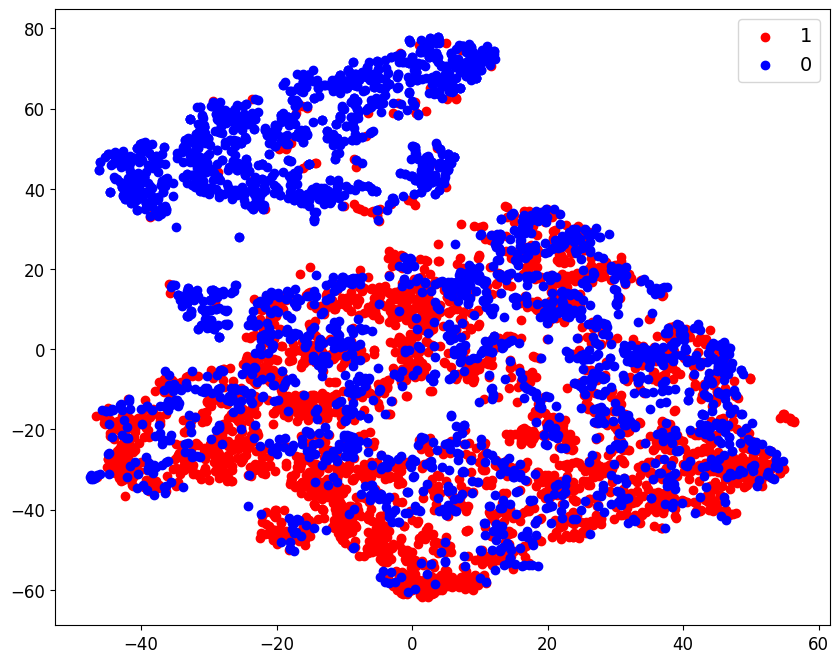

In [39]:
fig = plt.figure(figsize=(10, 8))

colors = {1: 'red', 0: 'blue'}
for label, color in colors.items():
    plt.scatter(
        table_tsne.loc[table_tsne['label'] == label, 'tsne1'],
        table_tsne.loc[table_tsne['label'] == label, 'tsne2'],
        c=color,
        label=label
    )

plt.legend();

## UMAP plot

### Initial plot

In [208]:
import umap

In [171]:
from sklearn.model_selection import train_test_split
train_table, test_table = train_test_split(
    table, 
    test_size=0.3, 
    random_state=42
)
x_train_table = train_table[useful_vars].reset_index(level=0, drop=True)
# y_train_table = x_train_table.pop('ana.mc.flag.isNuMuCC')
y_train_table = x_train_table.pop('EventType')

x_test_table = test_table[useful_vars].reset_index(level=0, drop=True)
# y_test_table = x_test_table.pop('ana.mc.flag.isNuMuCC')
y_test_table = x_test_table.pop('EventType')

# ss = StandardScaler()
# x_train_table[scale_vars] = ss.fit_transform(x_train_table[scale_vars])
# x_test_table[scale_vars] = ss.transform(x_test_table[scale_vars])

In [230]:
reducer = umap.UMAP(
    n_neighbors=50,
    n_components=2,
    n_epochs=1_000,
    # random_state=42
)
x_umap = reducer.fit_transform(x_train_table, y_train_table)

In [232]:
table_umap = pd.DataFrame(x_umap, columns=['x', 'y'])
table_umap['label'] = y_train_table.values
table_umap.index = y_train_table.index

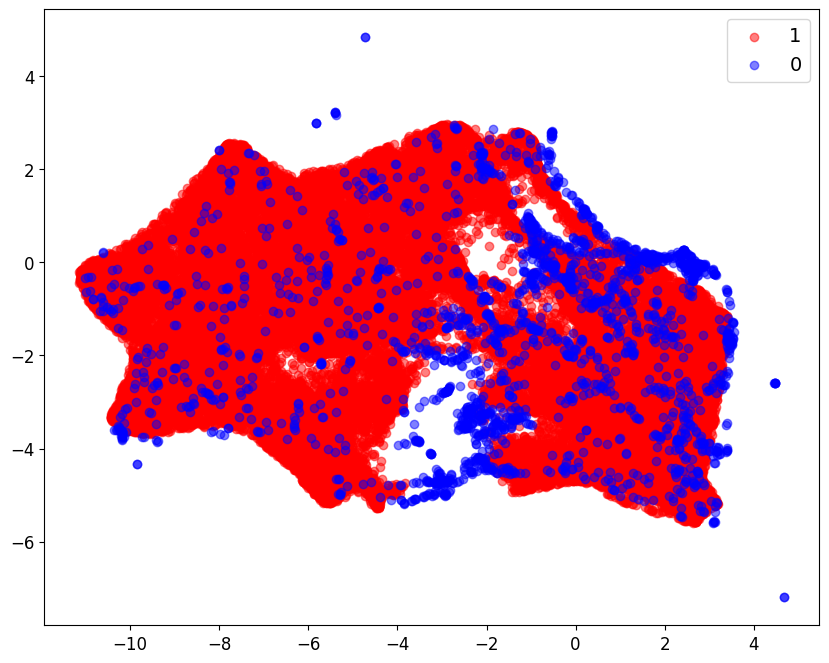

In [233]:
fig = plt.figure(figsize=(10, 8))

colors = {1: 'red', 0: 'blue'}
for label, color in colors.items():
    plt.scatter(
        table_umap.loc[table_umap['label'] == label, 'x'],
        table_umap.loc[table_umap['label'] == label, 'y'],
        c=color,
        alpha=0.5,
        label=label
    )

plt.legend();

In [234]:
full_cuts_table['ana.mc.flag.isNuMuCC'].value_counts()

ana.mc.flag.isNuMuCC
1.0    34079
0.0     1012
Name: count, dtype: int64

In [235]:
table['ana.mc.flag.isNuMuCC'].value_counts()

ana.mc.flag.isNuMuCC
1.0    66209
0.0     3198
Name: count, dtype: int64

In [236]:
table_umap[(table_umap['x'] < 0) & (table_umap['y'] < 10)]['label'].value_counts()

label
1.0    35019
0.0     1436
Name: count, dtype: int64

In [237]:
# Applying cuts post UMAP

In [238]:
index = list(set(full_cuts_table.index) & set(table_umap.index))

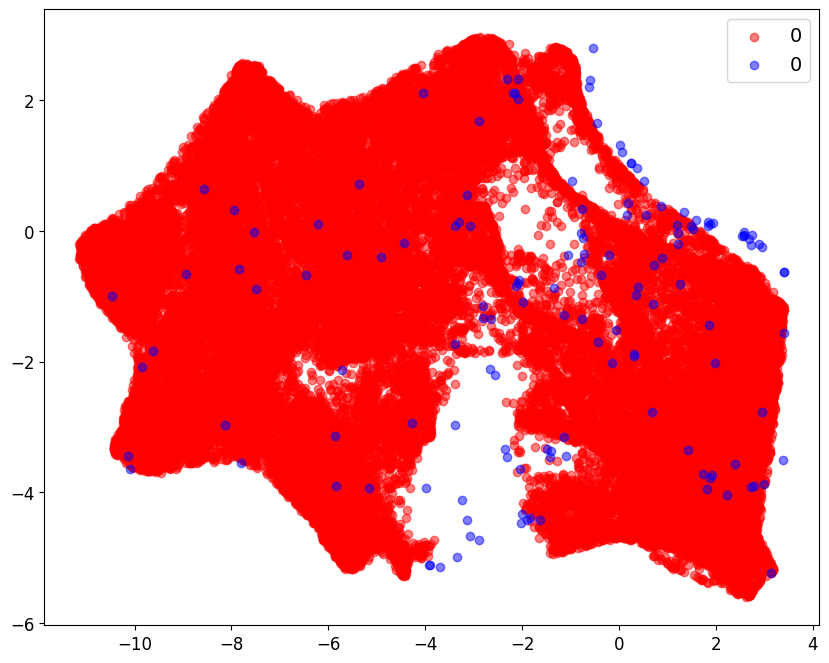

In [239]:
fig = plt.figure(figsize=(10, 8))

plt.scatter(
    table_umap.loc[table_umap['label'] == 1, 'x'],
    table_umap.loc[table_umap['label'] == 1, 'y'],
    c='red',
    alpha=0.5,
    label=label
)
plt.scatter(
    table_umap.loc[index, :].loc[table_umap['label'] == 0, 'x'],
    table_umap.loc[index, :].loc[table_umap['label'] == 0, 'y'],
    c='blue',
    alpha=0.5,
    label=label
)

plt.legend();

In [240]:
sig_len = len(
    table_umap[table_umap['label'] == 1][
        (table_umap[table_umap['label'] == 1]['x'] < 0) 
        & (table_umap[table_umap['label'] == 1]['y'] < 10)
    ]
)
_t = table_umap.loc[index, :]
bak_len = len(
    _t[_t['label'] == 0][
        (_t[_t['label'] == 0]['x'] < 0) 
        & (_t[_t['label'] == 0]['y'] < 10)
    ]
)
print('Sig:', sig_len)
print('Bak:', bak_len)

Sig: 35019
Bak: 87


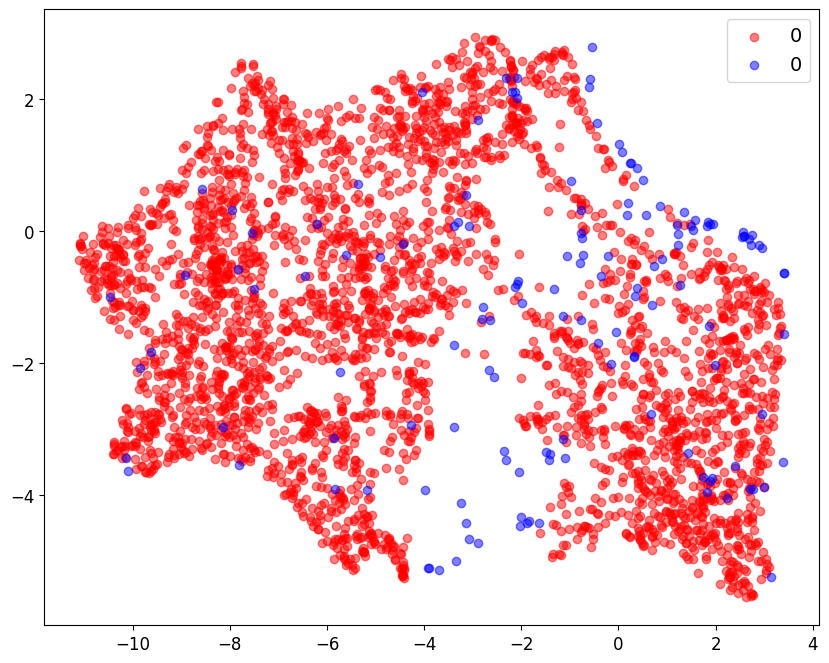

In [249]:
fig = plt.figure(figsize=(10, 8))

plt.scatter(
    table_umap.loc[index, :].loc[table_umap['label'] == 1, 'x'],
    table_umap.loc[index, :].loc[table_umap['label'] == 1, 'y'],
    c='red',
    alpha=0.5,
    label=label
)
plt.scatter(
    table_umap.loc[index, :].loc[table_umap['label'] == 0, 'x'],
    table_umap.loc[index, :].loc[table_umap['label'] == 0, 'y'],
    c='blue',
    alpha=0.5,
    label=label
)

plt.legend();

In [241]:
# Testing

In [242]:
x_test_umap = reducer.transform(x_test_table)

In [243]:
table_test_umap = pd.DataFrame(x_test_umap, columns=['x', 'y'])
table_test_umap['label'] = y_test_table.values
table_test_umap.index = y_test_table.index

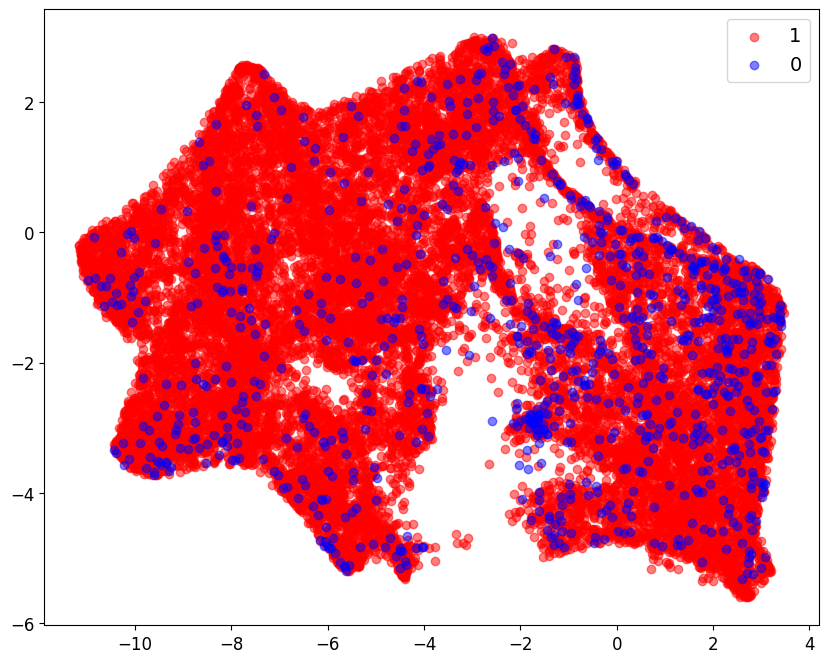

In [244]:
fig = plt.figure(figsize=(10, 8))

colors = {1: 'red', 0: 'blue'}
for label, color in colors.items():
    plt.scatter(
        table_test_umap.loc[table_test_umap['label'] == label, 'x'],
        table_test_umap.loc[table_test_umap['label'] == label, 'y'],
        c=color,
        alpha=0.5,
        label=label
    )

plt.legend();

In [245]:
table_test_umap[(table_test_umap['x'] < 0) & (table_test_umap['y'] < 10)]['label'].value_counts()

label
1.0    15184
0.0      598
Name: count, dtype: int64

In [246]:
index_test = list(set(full_cuts_table.index) & set(table_test_umap.index))

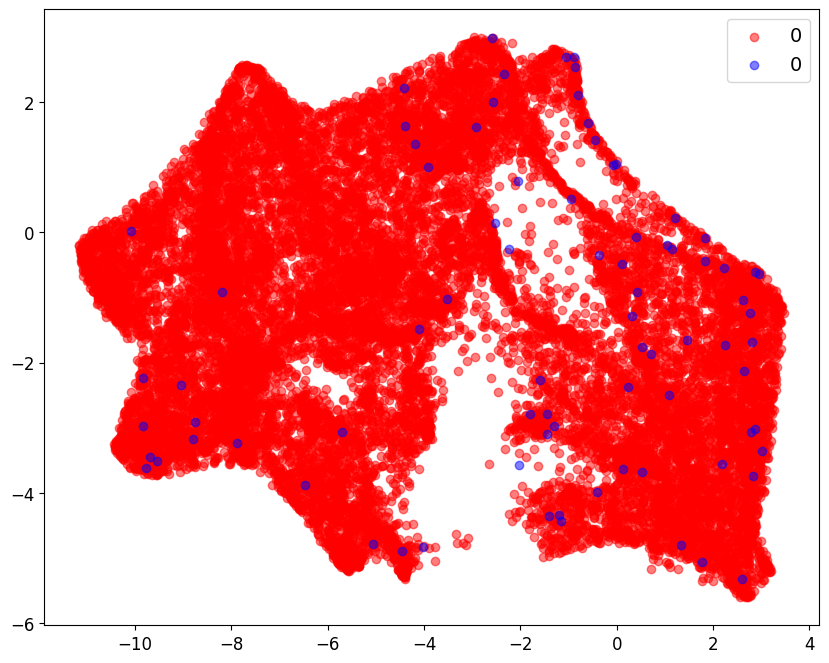

In [247]:
fig = plt.figure(figsize=(10, 8))

plt.scatter(
    table_test_umap.loc[table_test_umap['label'] == 1, 'x'],
    table_test_umap.loc[table_test_umap['label'] == 1, 'y'],
    c='red',
    alpha=0.5,
    label=label
)
plt.scatter(
    table_test_umap.loc[index_test, :].loc[table_test_umap['label'] == 0, 'x'],
    table_test_umap.loc[index_test, :].loc[table_test_umap['label'] == 0, 'y'],
    c='blue',
    alpha=0.5,
    label=label
)

plt.legend();

In [248]:
sig_len = len(
    table_test_umap[table_test_umap['label'] == 1][
        (table_test_umap[table_test_umap['label'] == 1]['x'] < 0) 
        & (table_test_umap[table_test_umap['label'] == 1]['y'] < 10)
    ]
)
_t = table_test_umap.loc[index_test, :]
bak_len = len(
    _t[_t['label'] == 0][
        (_t[_t['label'] == 0]['x'] < 0) 
        & (_t[_t['label'] == 0]['y'] < 10)
    ]
)
print('Sig:', sig_len)
print('Bak:', bak_len)

Sig: 15184
Bak: 49


### Testing UMAP

In [19]:
from sklearn.model_selection import train_test_split
train_table, test_table = train_test_split(
    table, 
    test_size=0.3, 
    random_state=42
)
x_train_table = train_table[x_vars].reset_index(level=0, drop=True)
y_train_table = x_train_table.pop('ana.mc.flag.isNuMuCC')

x_test_table = test_table[x_vars].reset_index(level=0, drop=True)
y_test_table = x_test_table.pop('ana.mc.flag.isNuMuCC')

ss = StandardScaler()
x_train_table[scale_vars] = ss.fit_transform(x_train_table[scale_vars])
x_test_table[scale_vars] = ss.transform(x_test_table[scale_vars])

In [24]:
reducer = umap.UMAP(
    n_neighbors=40,
    n_components=2,
    n_epochs=1_000,
    # low_memory=False,
    random_state=42
)

In [ ]:
x_umap = reducer.fit_transform(x_train_table, y_train_table)

In [ ]:
table_train_umap = pd.DataFrame(x_umap, columns=['umap1', 'umap2'])
table_train_umap['label'] = y_train_table.values

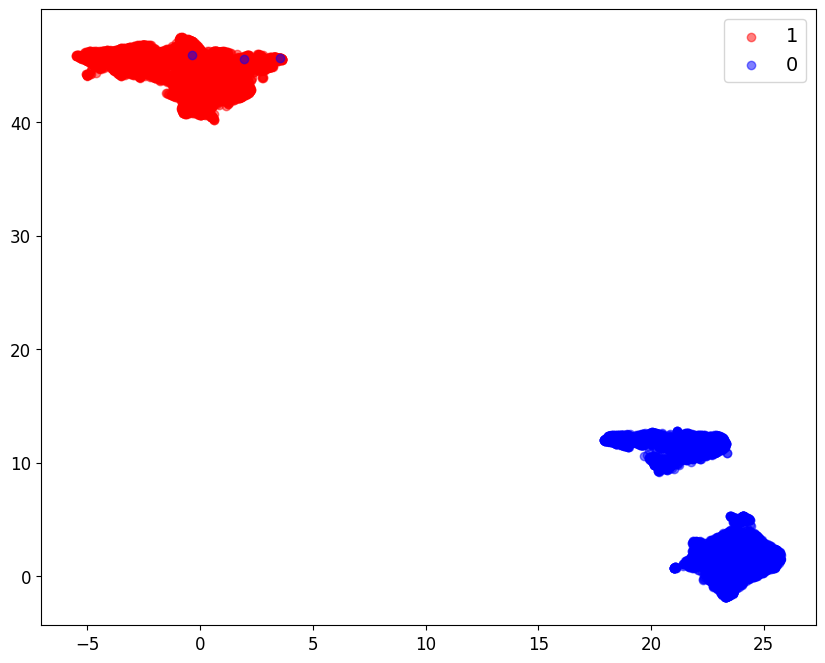

In [92]:
fig = plt.figure(figsize=(10, 8))

colors = {1: 'red', 0: 'blue'}
for label, color in colors.items():
    plt.scatter(
        table_train_umap.loc[table_train_umap['label'] == label, 'umap1'],
        table_train_umap.loc[table_train_umap['label'] == label, 'umap2'],
        c=color,
        alpha=0.5,
        label=label
    )

plt.legend();

In [93]:
reducer.transform

<bound method UMAP.transform of UMAP(n_epochs=1000, n_neighbors=40, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})>

In [94]:
x_test_umap = reducer.transform(x_test_table)

In [95]:
table_test_umap = pd.DataFrame(x_test_umap, columns=['umap1', 'umap2'])
table_test_umap['label'] = y_test_table.values

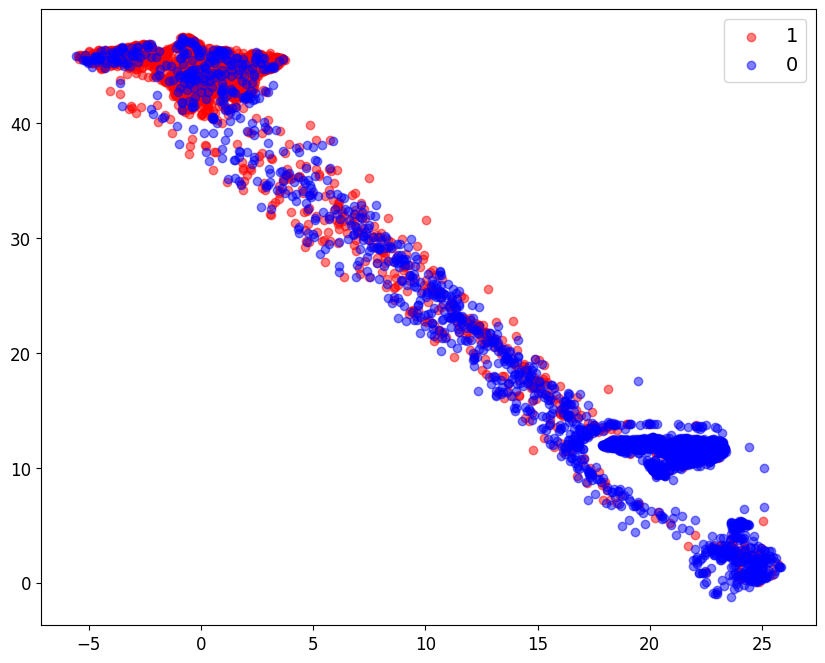

In [96]:
fig = plt.figure(figsize=(10, 8))

colors = {1: 'red', 0: 'blue'}
for label, color in colors.items():
    plt.scatter(
        table_test_umap.loc[table_test_umap['label'] == label, 'umap1'],
        table_test_umap.loc[table_test_umap['label'] == label, 'umap2'],
        c=color,
        alpha=0.5,
        label=label
    )

plt.legend();

In [97]:
table_test_umap['label'].value_counts()

label
1.0    2243
0.0    2152
Name: count, dtype: int64

In [99]:
table_test_umap[(table_test_umap['umap1'] < 5) & (table_test_umap['umap2'] > 35)]['label'].value_counts()

label
1.0    1770
0.0     334
Name: count, dtype: int64

### Best UMAP settings...

In [27]:
import umap

In [25]:
from sklearn.model_selection import train_test_split
train_table, test_table = train_test_split(
    table, 
    test_size=0.3, 
    random_state=42
)
x_train_table = train_table[useful_vars].reset_index(level=0, drop=True)
y_train_table = x_train_table.pop('EventType')

x_test_table = test_table[useful_vars].reset_index(level=0, drop=True)
y_test_table = x_test_table.pop('EventType')

ss = StandardScaler()
x_train_table[scale_vars] = ss.fit_transform(x_train_table[scale_vars])
x_test_table[scale_vars] = ss.transform(x_test_table[scale_vars])

In [24]:
n_neighbours_arr = [
    30, 50, 80
]

n_epocs_arr = [
    500, 1_000, 2_000
]

In [28]:
result = {}

for n_epochs in n_epocs_arr:
    for n_neighbours in n_neighbours_arr:
        result[(n_epochs, n_neighbours)] = {}

        reducer = umap.UMAP(
            n_neighbors=n_neighbours,
            n_components=2,
            n_epochs=n_epochs,
            random_state=42
        )

        # Training
        x_umap = reducer.fit_transform(x_train_table, y_train_table)

        table_train_umap = pd.DataFrame(x_umap, columns=['x', 'y'])
        table_train_umap['label'] = y_train_table.values

        result[(n_epochs, n_neighbours)]['train_umap'] = table_train_umap

        # Testing
        x_test_umap = reducer.transform(x_test_table)

        table_test_umap = pd.DataFrame(x_test_umap, columns=['x', 'y'])
        table_test_umap['label'] = y_test_table.values

        result[(n_epochs, n_neighbours)]['test_umap'] = table_test_umap



c:\Users\Shrey\OneDrive\Documents\GitHub\msci-project\.venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Shrey\OneDrive\Documents\GitHub\msci-project\.venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Shrey\OneDrive\Documents\GitHub\msci-project\.venv\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Shrey\OneDrive\Documents\GitHub\msci-project\.venv\lib\site-packages\umap\um

In [29]:
keys = list(result.keys())

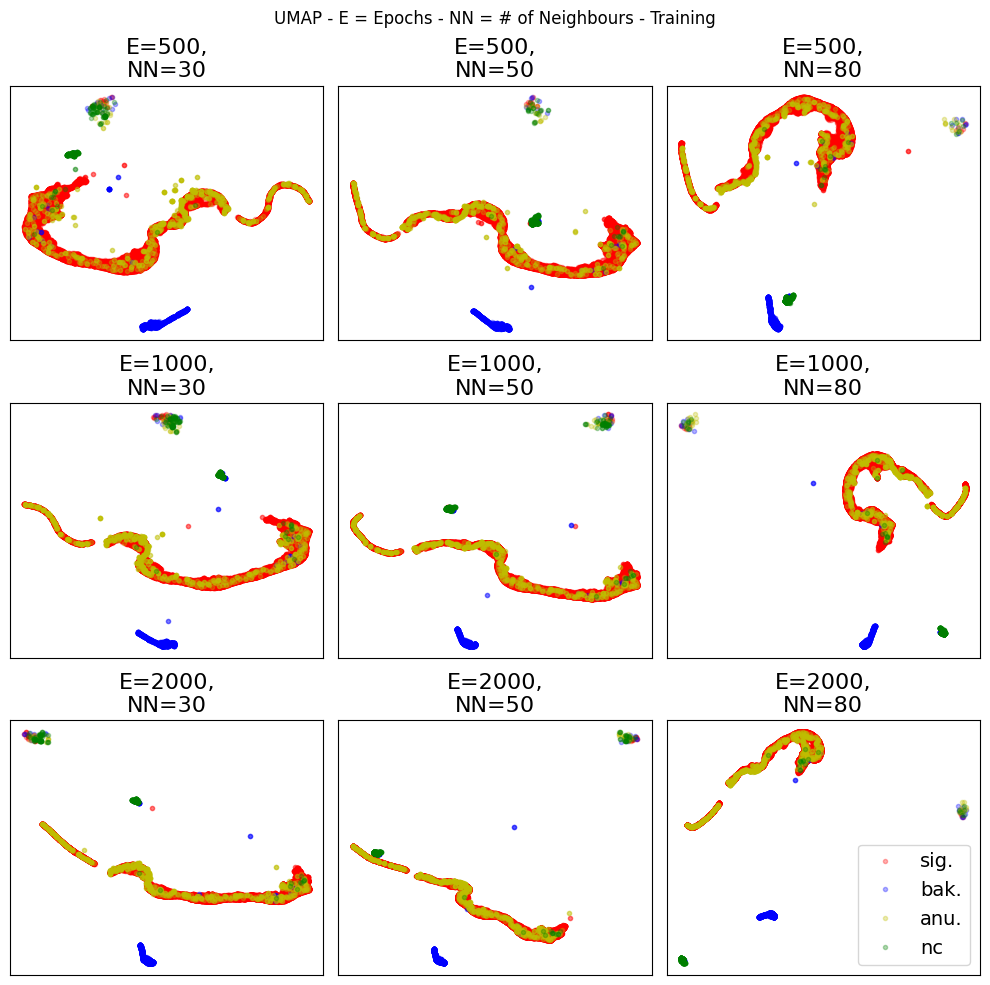

In [48]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

axs = axs.flatten()

# 0: Cosmic
# 1: NuMuCC
# 2: ANuMuCC
# 3: NuECC
# 4: NC

colours = {1: ('sig.', 'r'), 0: ('bak.', 'b'), 2: ('anu.', 'y'), 3: ('nc', 'g')}

for i, ax in enumerate(axs):
    table_umap = result[keys[i]]['train_umap']

    for label, (l, colour) in colours.items():
        ax.plot(
            table_umap.loc[table_umap['label'] == label, 'x'],
            table_umap.loc[table_umap['label'] == label, 'y'],
            f'.{colour}',
            alpha=0.3,
            label=l
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'E={keys[i][0]},\nNN={keys[i][1]}')

ax.legend()

fig.suptitle('UMAP - E = Epochs - NN = # of Neighbours - Training')

plt.tight_layout();
plt.tight_layout();

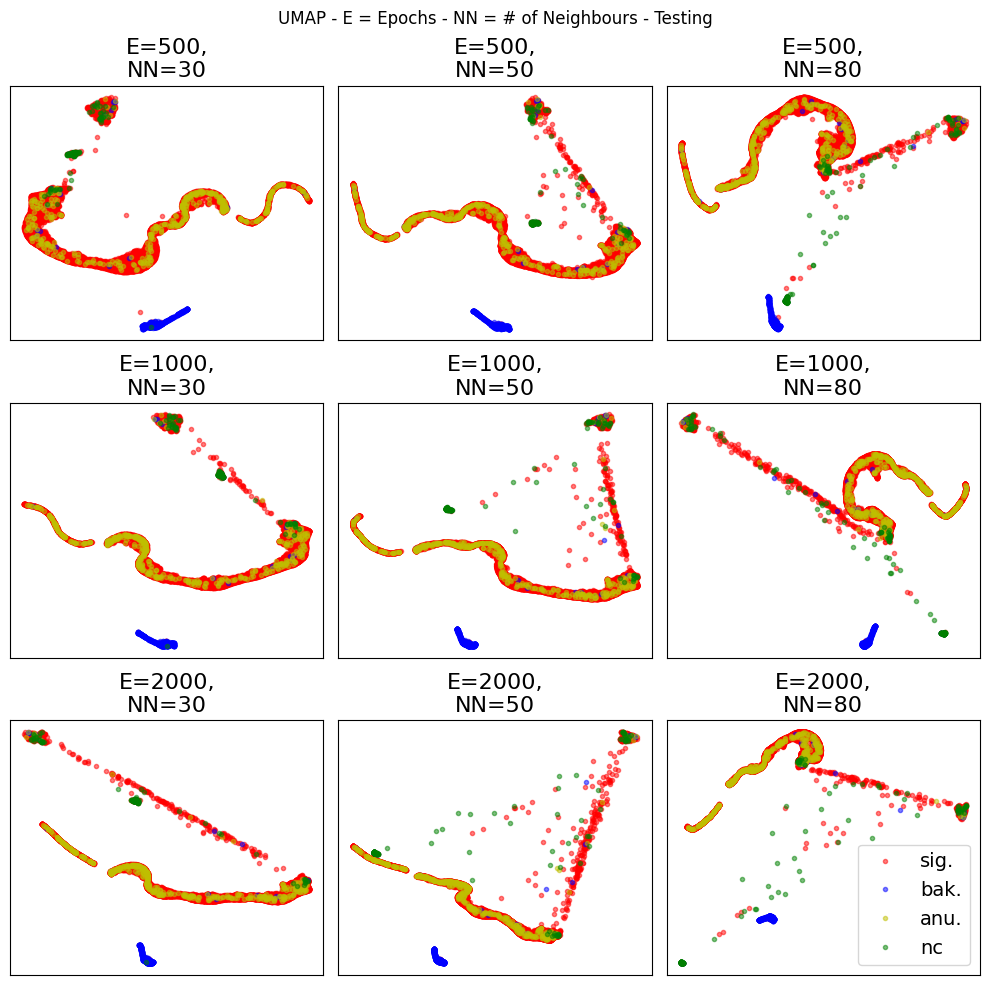

In [51]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

axs = axs.flatten()

# 0: Cosmic
# 1: NuMuCC
# 2: ANuMuCC
# 3: NuECC
# 4: NC

colours = {1: ('sig.', 'r'), 0: ('bak.', 'b'), 2: ('anu.', 'y'), 3: ('nc', 'g')}

for i, ax in enumerate(axs):
    table_umap = result[keys[i]]['test_umap']

    for label, (l, colour) in colours.items():
        ax.plot(
            table_umap.loc[table_umap['label'] == label, 'x'],
            table_umap.loc[table_umap['label'] == label, 'y'],
            f'.{colour}',
            alpha=0.5,
            label=l
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'E={keys[i][0]},\nNN={keys[i][1]}')

ax.legend()

fig.suptitle('UMAP - E = Epochs - NN = # of Neighbours - Testing')

plt.tight_layout();

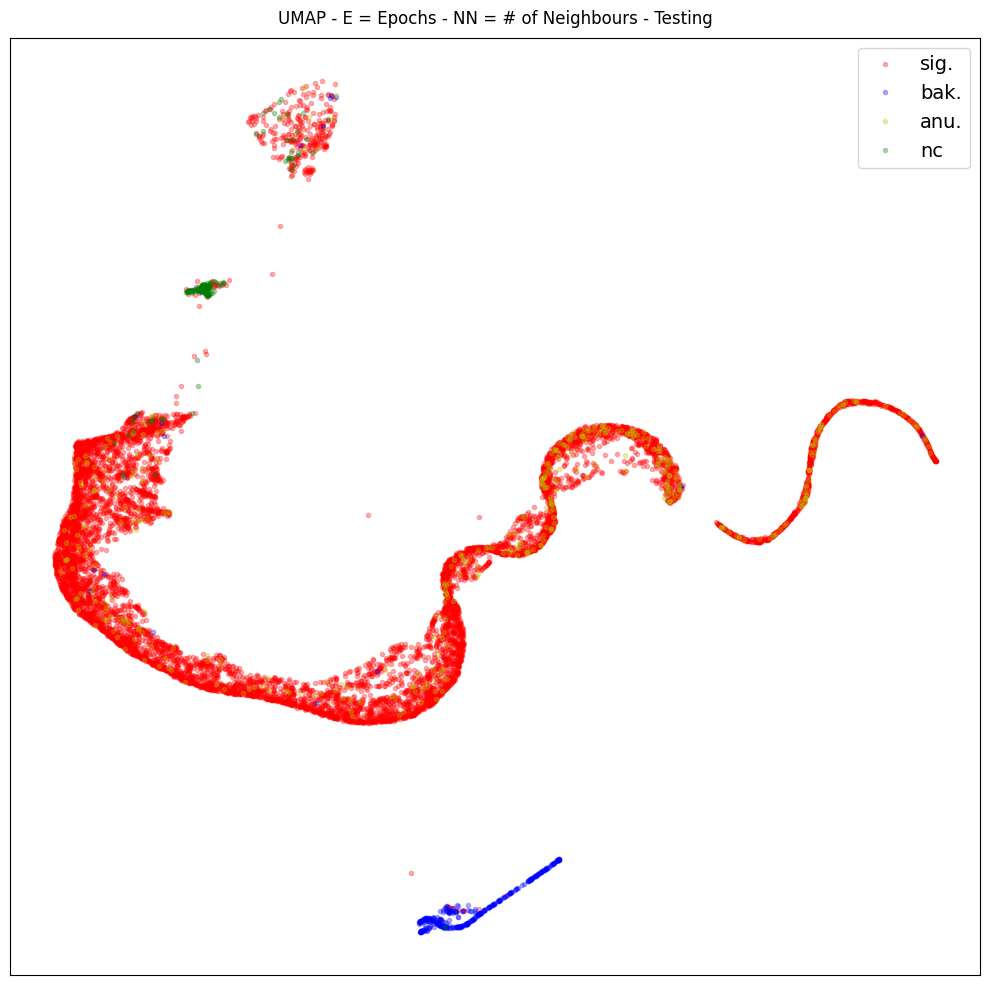

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))

# 0: Cosmic
# 1: NuMuCC
# 2: ANuMuCC
# 3: NuECC
# 4: NC

colours = {1: ('sig.', 'r'), 0: ('bak.', 'b'), 2: ('anu.', 'y'), 3: ('nc', 'g')}

table_umap = result[keys[0]]['test_umap']

for label, (l, colour) in colours.items():
    ax.plot(
        table_umap.loc[table_umap['label'] == label, 'x'],
        table_umap.loc[table_umap['label'] == label, 'y'],
        f'.{colour}',
        alpha=0.3,
        label=l
    )
    ax.set_xticks([])
    ax.set_yticks([])

ax.legend()

fig.suptitle('UMAP - E = Epochs - NN = # of Neighbours - Testing')

plt.tight_layout();

In [53]:
# =======================================================

In [55]:
n_neighbours_arr = [
    10, 20, 30
]

n_epocs_arr = [
    100, 300, 400
]

In [62]:
result = {}

for n_epochs in n_epocs_arr:
    for n_neighbours in n_neighbours_arr:
        result[(n_epochs, n_neighbours)] = {}

        reducer = umap.UMAP(
            n_neighbors=n_neighbours,
            n_components=2,
            n_epochs=n_epochs
        )

        # Training
        x_umap = reducer.fit_transform(x_train_table, y_train_table)

        table_train_umap = pd.DataFrame(x_umap, columns=['x', 'y'])
        table_train_umap['label'] = y_train_table.values

        result[(n_epochs, n_neighbours)]['train_umap'] = table_train_umap

        # Testing
        x_test_umap = reducer.transform(x_test_table)

        table_test_umap = pd.DataFrame(x_test_umap, columns=['x', 'y'])
        table_test_umap['label'] = y_test_table.values

        result[(n_epochs, n_neighbours)]['test_umap'] = table_test_umap



In [63]:
keys = list(result.keys())

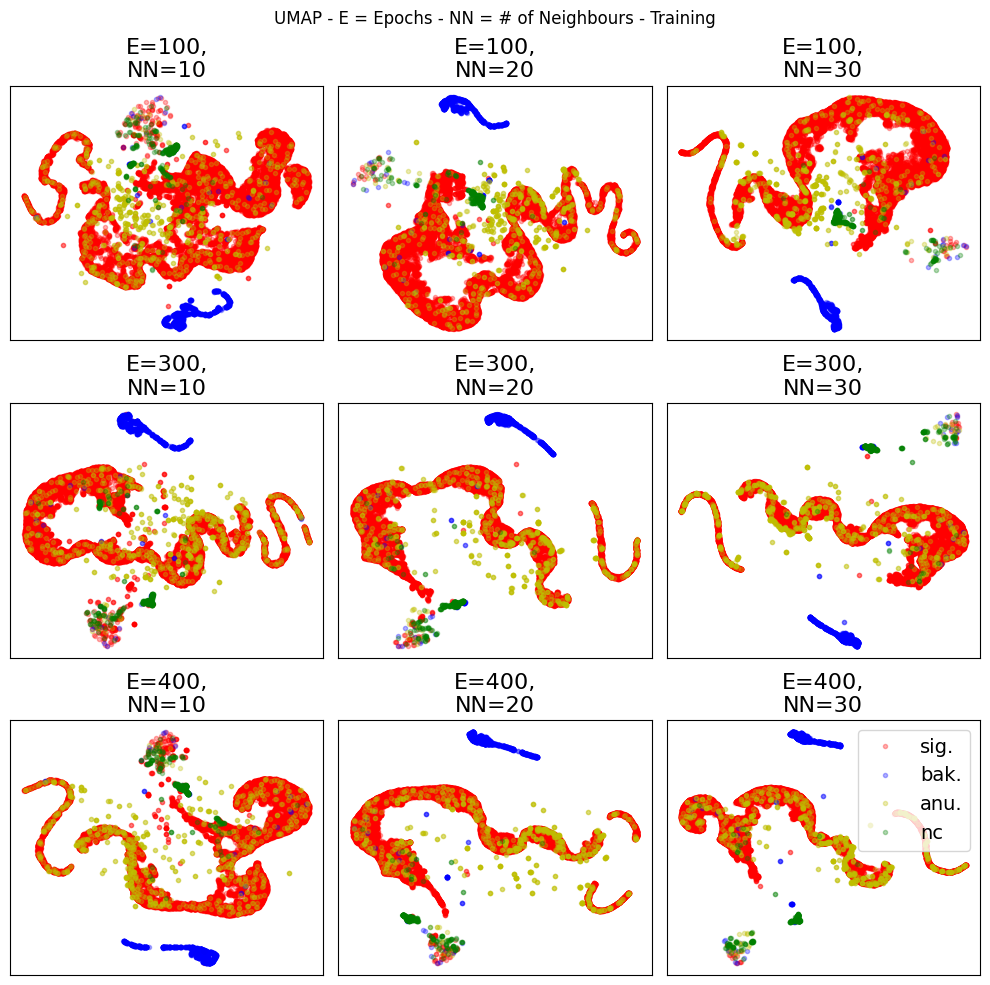

In [64]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

axs = axs.flatten()

# 0: Cosmic
# 1: NuMuCC
# 2: ANuMuCC
# 3: NuECC
# 4: NC

colours = {1: ('sig.', 'r'), 0: ('bak.', 'b'), 2: ('anu.', 'y'), 3: ('nc', 'g')}

for i, ax in enumerate(axs):
    table_umap = result[keys[i]]['train_umap']

    for label, (l, colour) in colours.items():
        ax.plot(
            table_umap.loc[table_umap['label'] == label, 'x'],
            table_umap.loc[table_umap['label'] == label, 'y'],
            f'.{colour}',
            alpha=0.3,
            label=l
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'E={keys[i][0]},\nNN={keys[i][1]}')

ax.legend()

fig.suptitle('UMAP - E = Epochs - NN = # of Neighbours - Training')

plt.tight_layout();
plt.tight_layout();

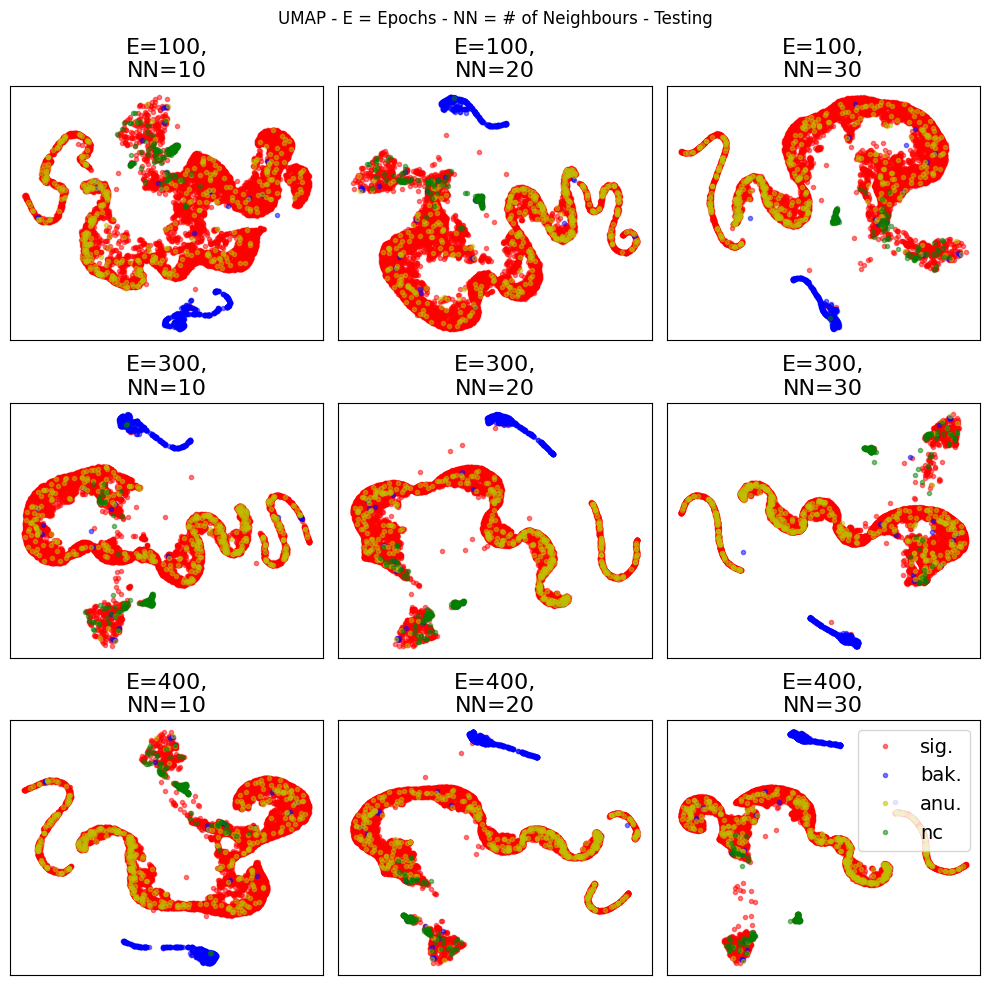

In [65]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

axs = axs.flatten()

# 0: Cosmic
# 1: NuMuCC
# 2: ANuMuCC
# 3: NuECC
# 4: NC

colours = {1: ('sig.', 'r'), 0: ('bak.', 'b'), 2: ('anu.', 'y'), 3: ('nc', 'g')}

for i, ax in enumerate(axs):
    table_umap = result[keys[i]]['test_umap']

    for label, (l, colour) in colours.items():
        ax.plot(
            table_umap.loc[table_umap['label'] == label, 'x'],
            table_umap.loc[table_umap['label'] == label, 'y'],
            f'.{colour}',
            alpha=0.5,
            label=l
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'E={keys[i][0]},\nNN={keys[i][1]}')

ax.legend()

fig.suptitle('UMAP - E = Epochs - NN = # of Neighbours - Testing')

plt.tight_layout();

## More t-SNE plots

In [250]:
tsne = TSNE(
    n_components=2,
    perplexity=50,
    # n_iter=2_000,
    verbose=1,
    random_state=42
)
x_tsne = tsne.fit_transform(x_table, y_table)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 40734 samples in 0.125s...


[t-SNE] Computed neighbors for 40734 samples in 13.585s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40734
[t-SNE] Computed conditional probabilities for sample 2000 / 40734
[t-SNE] Computed conditional probabilities for sample 3000 / 40734
[t-SNE] Computed conditional probabilities for sample 4000 / 40734
[t-SNE] Computed conditional probabilities for sample 5000 / 40734
[t-SNE] Computed conditional probabilities for sample 6000 / 40734
[t-SNE] Computed conditional probabilities for sample 7000 / 40734
[t-SNE] Computed conditional probabilities for sample 8000 / 40734
[t-SNE] Computed conditional probabilities for sample 9000 / 40734
[t-SNE] Computed conditional probabilities for sample 10000 / 40734
[t-SNE] Computed conditional probabilities for sample 11000 / 40734
[t-SNE] Computed conditional probabilities for sample 12000 / 40734
[t-SNE] Computed conditional probabilities for sample 13000 / 40734
[t-SNE] Computed conditional probabilities for sample 14000 / 4073

In [254]:
table_tsne = pd.DataFrame(x_tsne, columns=['tsne1', 'tsne2'])
table_tsne['label'] = y_table.values

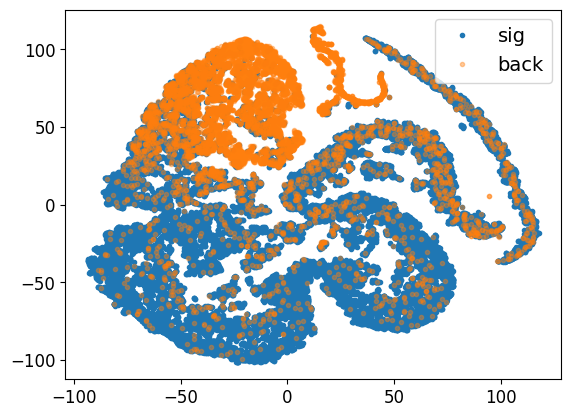

In [255]:
plt.plot(
    table_tsne[table_tsne['label'] == 1]['tsne1'], 
    table_tsne[table_tsne['label'] == 1]['tsne2'], 
    '.',
    label='sig'
)
plt.plot(
    table_tsne[table_tsne['label'] != 1]['tsne1'], 
    table_tsne[table_tsne['label'] != 1]['tsne2'], 
    '.',
    alpha=0.4,
    label='back'
)
plt.legend();

In [66]:
plt.plot(
    table_tsne[table_tsne['label'] == 1]['tsne1'], 
    table_tsne[table_tsne['label'] == 1]['tsne2'], 
    '.',
    alpha=0.1,
    label='numucc'
)
plt.plot(
    table_tsne[table_tsne['label'] == 4]['tsne1'], 
    table_tsne[table_tsne['label'] == 4]['tsne2'], 
    '.',
    alpha=0.1,
    label='nc'
)
plt.plot(
    table_tsne[table_tsne['label'] == 0]['tsne1'], 
    table_tsne[table_tsne['label'] == 0]['tsne2'], 
    '.',
    alpha=0.1,
    label='back'
)
plt.plot(
    table_tsne[table_tsne['label'] == 2]['tsne1'], 
    table_tsne[table_tsne['label'] == 2]['tsne2'], 
    '.',
    alpha=0.1,
    label='anumucc'
)
plt.plot(
    table_tsne[table_tsne['label'] == 3]['tsne1'], 
    table_tsne[table_tsne['label'] == 3]['tsne2'], 
    '.',
    alpha=0.1,
    label='nuecc'
)
plt.legend();

NameError: name 'table_tsne' is not defined

## More UMAP plots

In [257]:
from sklearn.model_selection import train_test_split
train_table, test_table = train_test_split(
    table, 
    test_size=0.3, 
    random_state=42
)
x_train_table = train_table[useful_vars].reset_index(level=0, drop=True)
y_train_table = x_train_table.pop('EventType')

x_test_table = test_table[useful_vars].reset_index(level=0, drop=True)
y_test_table = x_test_table.pop('EventType')

ss = StandardScaler()
x_train_table[scale_vars] = ss.fit_transform(x_train_table[scale_vars])
x_test_table[scale_vars] = ss.transform(x_test_table[scale_vars])

In [258]:
reducer = umap.UMAP(
    n_neighbors=50,
    n_components=2,
    n_epochs=1_000,
    # random_state=42
)
x_umap = reducer.fit_transform(x_train_table, y_train_table)

In [259]:
table_umap = pd.DataFrame(x_umap, columns=['x', 'y'])
table_umap['label'] = y_train_table.values

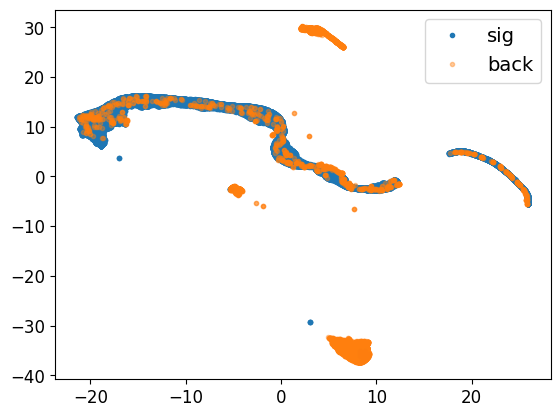

In [260]:
plt.plot(
    table_umap[table_umap['label'] == 1]['x'], 
    table_umap[table_umap['label'] == 1]['y'], 
    '.',
    label='sig'
)
plt.plot(
    table_umap[table_umap['label'] != 1]['x'], 
    table_umap[table_umap['label'] != 1]['y'], 
    '.',
    alpha=0.4,
    label='back'
)
plt.legend();

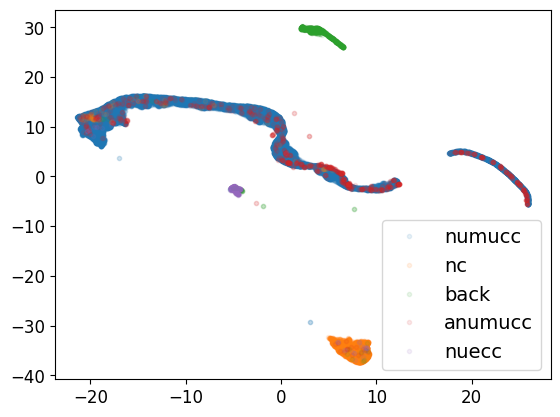

In [261]:
plt.plot(
    table_umap[table_umap['label'] == 1]['x'], 
    table_umap[table_umap['label'] == 1]['y'], 
    '.',
    alpha=0.1,
    label='numucc'
)
plt.plot(
    table_umap[table_umap['label'] == 4]['x'], 
    table_umap[table_umap['label'] == 4]['y'], 
    '.',
    alpha=0.1,
    label='nc'
)
plt.plot(
    table_umap[table_umap['label'] == 0]['x'], 
    table_umap[table_umap['label'] == 0]['y'], 
    '.',
    alpha=0.1,
    label='back'
)
plt.plot(
    table_umap[table_umap['label'] == 2]['x'], 
    table_umap[table_umap['label'] == 2]['y'], 
    '.',
    alpha=0.1,
    label='anumucc'
)
plt.plot(
    table_umap[table_umap['label'] == 3]['x'], 
    table_umap[table_umap['label'] == 3]['y'], 
    '.',
    alpha=0.1,
    label='nuecc'
)
plt.legend();

In [262]:
x_test_umap = reducer.transform(x_test_table)

In [263]:
table_train_umap = pd.DataFrame(x_test_umap, columns=['x', 'y'])
table_train_umap['label'] = y_test_table.values

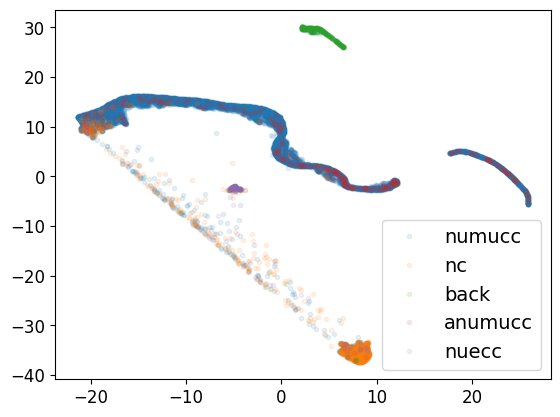

In [264]:
plt.plot(
    table_train_umap[table_train_umap['label'] == 1]['x'], 
    table_train_umap[table_train_umap['label'] == 1]['y'], 
    '.',
    alpha=0.1,
    label='numucc'
)
plt.plot(
    table_train_umap[table_train_umap['label'] == 4]['x'], 
    table_train_umap[table_train_umap['label'] == 4]['y'], 
    '.',
    alpha=0.1,
    label='nc'
)
plt.plot(
    table_train_umap[table_train_umap['label'] == 0]['x'], 
    table_train_umap[table_train_umap['label'] == 0]['y'], 
    '.',
    alpha=0.1,
    label='back'
)
plt.plot(
    table_train_umap[table_train_umap['label'] == 2]['x'], 
    table_train_umap[table_train_umap['label'] == 2]['y'], 
    '.',
    alpha=0.1,
    label='anumucc'
)
plt.plot(
    table_train_umap[table_train_umap['label'] == 3]['x'], 
    table_train_umap[table_train_umap['label'] == 3]['y'], 
    '.',
    alpha=0.1,
    label='nuecc'
)
plt.legend();

In [265]:
table_train_umap[(table_train_umap['x'] < 19) & (table_train_umap['y'] < 19)]['label'].value_counts()

label
1.0    8730
4.0    1677
2.0     363
3.0     161
0.0      31
Name: count, dtype: int64

In [266]:
full_cuts_table.reset_index(drop=True)[:len(table_train_umap)]['ana.mc.flag.isNuMuCC'].value_counts()

ana.mc.flag.isNuMuCC
1.0    11844
0.0      377
Name: count, dtype: int64

In [267]:
full_cuts_table.reset_index(drop=True)[:len(table_train_umap)]['ana.mc.flag.isANuMuCC'].value_counts()

ana.mc.flag.isANuMuCC
0.0    11877
1.0      344
Name: count, dtype: int64

## PCA

In [67]:
from sklearn.decomposition import PCA

In [181]:
from sklearn.model_selection import train_test_split
train_table, test_table = train_test_split(
    table, 
    test_size=0.3, 
    random_state=42
)
x_train_table = train_table[useful_vars].reset_index(level=0, drop=True)
y_train_table = x_train_table.pop('EventType')
# y_train_table = (x_train_table['EventType'] == 1.) * 1 + (x_train_table['EventType'] == 2.) * 1.
# x_train_table.pop('EventType')

x_test_table = test_table[useful_vars].reset_index(level=0, drop=True)
y_test_table = x_test_table.pop('EventType')
# y_test_table = (x_test_table['EventType'] == 1.) * 1. + (x_test_table['EventType'] == 2.) * 1.
# x_test_table.pop('EventType')

In [203]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_table, y_table)

In [204]:
table_pca = pd.DataFrame(x_pca, columns=['x', 'y'])
table_pca['label'] = y_table.values

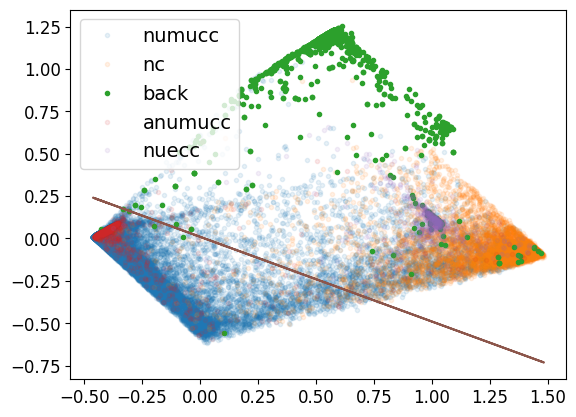

In [205]:
plt.plot(
    table_pca[table_pca['label'] == 1]['x'], 
    table_pca[table_pca['label'] == 1]['y'], 
    '.',
    alpha=0.1,
    label='numucc'
)
plt.plot(
    table_pca[table_pca['label'] == 4]['x'], 
    table_pca[table_pca['label'] == 4]['y'], 
    '.',
    alpha=0.1,
    label='nc'
)
plt.plot(
    table_pca[table_pca['label'] == 0]['x'], 
    table_pca[table_pca['label'] == 0]['y'], 
    '.',
    # alpha=0.1,
    label='back'
)
plt.plot(
    table_pca[table_pca['label'] == 2]['x'], 
    table_pca[table_pca['label'] == 2]['y'], 
    '.',
    alpha=0.1,
    label='anumucc'
)
plt.plot(
    table_pca[table_pca['label'] == 3]['x'], 
    table_pca[table_pca['label'] == 3]['y'], 
    '.',
    alpha=0.1,
    label='nuecc'
)
_x = table_pca['x']
_y = -0.5 * _x + 0.01
plt.plot(_x, _y)
plt.legend();

In [206]:
table_pca[table_pca['y'] < _y]

x         y  label
0     -0.446569  0.021153    1.0
1     -0.419027  0.043448    1.0
3     -0.413090  0.047097    1.0
4     -0.052197 -0.360479    1.0
5     -0.299273  0.060237    1.0
...         ...       ...    ...
40727 -0.436051  0.027214    1.0
40729 -0.448922  0.019809    1.0
40730 -0.392164  0.059178    1.0
40732 -0.424604 -0.032451    1.0
40733 -0.396286  0.057984    1.0

[30474 rows x 3 columns]

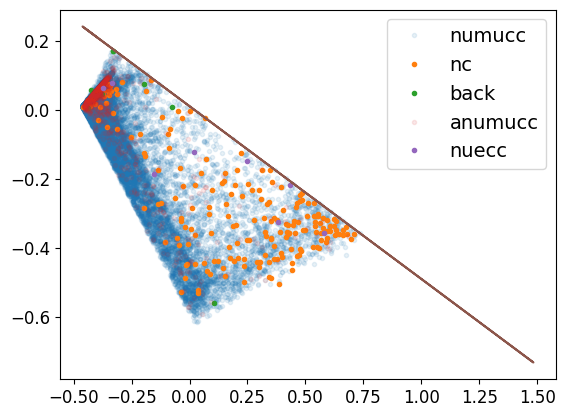

In [207]:
plt.plot(
    table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 1]['x'], 
    table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 1]['y'], 
    '.',
    alpha=0.1,
    label='numucc'
)
plt.plot(
    table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 4]['x'], 
    table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 4]['y'], 
    '.',
    label='nc'
)
plt.plot(
    table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 0]['x'], 
    table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 0]['y'], 
    '.',
    label='back'
)
plt.plot(
    table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 2]['x'], 
    table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 2]['y'], 
    '.',
    alpha=0.1,
    label='anumucc'
)
plt.plot(
    table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 3]['x'], 
    table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 3]['y'], 
    '.',
    label='nuecc'
)
plt.plot(_x, _y)
plt.legend();

In [208]:
(
    len(table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 1])
    + len(table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 2])
)

30261

In [220]:
len(table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 2])

1286

In [209]:
(
    len(table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 0])
    + len(table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 3])
    + len(table_pca[table_pca['y'] < _y][table_pca[table_pca['y'] < _y]['label'] == 4])
)

213

In [211]:
y_table.value_counts()

EventType
1.0    31752
4.0     5636
0.0     1417
2.0     1355
3.0      574
Name: count, dtype: int64

In [215]:
full_cuts_table['ana.mc.flag.isNuMuCC'].value_counts()

ana.mc.flag.isNuMuCC
1.0    14149
0.0      440
Name: count, dtype: int64

In [216]:
full_cuts_table['ana.mc.flag.isANuMuCC'].value_counts()

ana.mc.flag.isANuMuCC
0.0    14185
1.0      404
Name: count, dtype: int64

In [217]:
14149 + 404

14553